# Data

The sentiment analysis model within this notebook uses publicly available datasets:

1. Large Movie Review Dataset: https://ai.stanford.edu/~amaas/data/sentiment/
2. Sentiment Polarity Dataset (v1 and v2): https://www.cs.cornell.edu/people/pabo/movie-review-data/
3. Rotten Tomatoes web scraped critic reviews: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset/

All data is contained in the "data" directory (not committed in this repo).
The code below assumes the same directory structure as the original datasets under the root "data" folder.

In [1]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

"""
For details on implementation of dataset loading and other utils check out dataset_utils.py

CONVENTION: label 0 --> negative review
            label 1 --> positive review
"""

#Main training set - Large Movie Review Dataset (IMDB)
((imdb_train_texts, imdb_train_labels), (imdb_test_texts, imdb_test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

#Rotten tomatoes critic dataset
rotten_train_texts, rotten_train_labels, short_rotten_test, random_rotten_test, pos_rotten_test, neg_rotten_test = load_rotten_split(ROTTEN_PATH, n_train_samples=12000)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_len_dist(dataset_name, texts):
    data=[len(text) for text in texts]
    median = np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Length of sample over number of samples: {dataset_name}")
    plt.xlabel("Length of a sample")
    plt.ylabel("Number of samples")
    plt.show()
    
def plot_wordcount_dist(dataset_name, texts):
    data=[len(text.split(" ")) for text in texts]
    median=np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Number of words: {dataset_name}")
    plt.xlabel("Number of words in a sample")
    plt.ylabel("Number of samples")
    plt.show()

# for title, texts in [('IMDB_train', imdb_train_texts), ('IMDB_test', imdb_test_texts), ('polarity_v1', v1_texts), ('polarity_v2',v2_texts),
#                      ('rotten_train', rotten_train_texts), ('rotten_test', rotten_test_texts)]:
#     plot_len_dist(title, texts)
#     plot_wordcount_dist(title, texts)
    

In [3]:
def display_dataset_info(texts, labels, name):
    print(f"Dataset: {name}.")
    print(f"Total number of samples: {len(texts)}")
    print(f"Positive reviews total: {sum(label==1 for label in labels)}")
    print(f"Negative reviews total: {sum(label==0 for label in labels)}")
    print("--------------------------------------")

for texts, labels, name in [(imdb_train_texts, imdb_train_labels, 'imdb_train'), (imdb_test_texts, imdb_test_labels, 'imdb_test'),
                            (v1_texts, v1_labels, 'polarity_v1'), (v2_texts, v2_labels, 'polarity_v2'),
                            (rotten_train_texts, rotten_train_labels, 'rotten tomatoes train')]:
    
    display_dataset_info(texts, labels, name)

Dataset: imdb_train.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: imdb_test.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: polarity_v1.
Total number of samples: 10662
Positive reviews total: 5331
Negative reviews total: 5331
--------------------------------------
Dataset: polarity_v2.
Total number of samples: 2000
Positive reviews total: 1000
Negative reviews total: 1000
--------------------------------------
Dataset: rotten tomatoes train.
Total number of samples: 12000
Positive reviews total: 6000
Negative reviews total: 6000
--------------------------------------


In [4]:
from sklearn.model_selection import train_test_split

train_texts_v1, test_texts_v1, train_labels_v1, test_labels_v1 = train_test_split(v1_texts, v1_labels, test_size=0.33, random_state=42)

train_texts = imdb_train_texts + rotten_train_texts + train_texts_v1
train_labels = imdb_train_labels + rotten_train_labels + train_labels_v1

seed=10
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

print(f"Training set size: {len(train_texts)}")

Training set size: 44143


In [5]:
short_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) < 25]
rest_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) >= 25]
short_test = short_test_v1 + short_rotten_test

long_test_v2 = [(v2_labels[index], text) for index, text in enumerate(v2_texts) if len(text.split(" ")) > 300]
long_test_imdb = [(imdb_test_labels[index], text) for index, text in enumerate(imdb_test_texts) if len(text.split(" ")) > 300]

long_test = long_test_v2 + long_test_imdb

In [6]:
random.seed(seed)
random.shuffle(short_test)
random.seed(seed)
random.shuffle(long_test)

# Encoding

In [18]:
import torch

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


MAX_FEATURES = 15000
transformer_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=5, ngram_range=(1,3), sublinear_tf=False, smooth_idf=True)),
    ('select', SelectKBest(k=MAX_FEATURES, score_func=f_classif))
])

#vect2 = TfidfVectorizer(min_df=10, max_features=20000, sublinear_tf=False, ngram_range=(1,2))

transformed_train = transformer_pipeline.fit_transform(train_texts, train_labels)
#transformed_train = vect2.fit_transform(train_texts)


X_train = torch.from_numpy(transformed_train.toarray()).to(dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

vectorizer = transformer_pipeline.named_steps['vect']
selector   = transformer_pipeline.named_steps['select']

## The model

In [19]:
from torch import nn

input_dim = X_train.shape[1]

class SentimentCLF(nn.Module):
    def __init__(self, n_units, dropout_p, n_hidden):
        super().__init__()
        
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.ReLU(),
            nn.Dropout(p=dropout_p)
        )
        
        for i in range(n_hidden):
            self.linear_stack.append(nn.Linear(n_units, n_units))
            #self.linear_stack.append(nn.BatchNorm1d(num_features=n_units))
            self.linear_stack.append(nn.ReLU())
        
        self.final_linear=nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(n_units, 1)
        )

    def forward(self, x):
        out = self.linear_stack(x)
        #dropped = self.dropout(out)
        logits = self.final_linear(out)
        
        return logits

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {device}")

Using: cuda


## Training

For training, we find the ideal neural network for our needs by running experiments. Each experiment corresponds to a different model with different parameters.

### Experiments directory structure

Top directory: `models`. Within this directory there are multiple directories that correspond to different settings of the vectorizer (text encoding + feature selection). E.g. folder `min_df_10_ft_5000best` contains models for which the training data was encoded using tfidfvectorizer with parameters min_df=10 and then following that we select 5000best features (select k best).

Within each of the directories corresponding to the vectorizer settings, there are multiple experiments: exp1, exp2, .. etc.
Each experiment contains the model (pkl file), training history and results on the test sets at the bottom of the notebook.

In [34]:
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, LoadInitState, LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LinearLR, StepLR, ExponentialLR

model_dirs = sorted(os.listdir('models'))

#top directory regards vectorizer settings
vect_dir_idx = 3
topdir = model_dirs[vect_dir_idx]

#experiments within chosen vectorizer settings directory
experiments = sorted(os.listdir(f'models/{topdir}'))

if len(experiments) == 0:
    curr_number = 1
else:
    curr_number = int(experiments[-1][-1])
    
next_number = curr_number + 1

dirname_curr=f'models/{topdir}/exp{curr_number}'
f_pickle_curr=f'exp{curr_number}.pkl'

dirname_next=f'models/{topdir}/exp{next_number}'
f_pickle_next=f'exp{next_number}.pkl'

#checkpoints for saving the model during training. cp_current corresponds to the last experiment.
#When we switch the callback to cp_next, this starts a new experiment

cp_current = Checkpoint(monitor='valid_loss_best', dirname=dirname_curr, f_pickle=f_pickle_curr)
cp_next    = Checkpoint(monitor='valid_loss_best', dirname=dirname_next, f_pickle=f_pickle_next)
load_state = LoadInitState(cp_current)

lr_scheduler = ('lr_scheduler', LRScheduler(policy=ReduceLROnPlateau, mode='min', factor=0.1, patience=5))
lr_sched_step = ('lr_scheduler', LRScheduler(policy=StepLR, step_size=10, gamma=0.05))
lr_sched_linear = ('lr_scheduler', LRScheduler(policy=LinearLR, start_factor=0.3, end_factor=1, total_iters=7))
#lr_sched_exp = ('lr_scheduler', LRScheduler(policy=ExponentialLR, g))

net = NeuralNetClassifier(
    module=SentimentCLF,
    module__n_units=650,
    module__dropout_p=0.5,
    module__n_hidden=2,
    lr = 0.001,
    criterion=nn.BCEWithLogitsLoss,   
    device=device,
    max_epochs=10,
    optimizer=torch.optim.Adam,
    #optimizer__momentum=0.99,
    optimizer__weight_decay=0.001,
    batch_size=64,
    iterator_train__shuffle=True,
    #callbacks = [cp_current, load_state],
    callbacks = [cp_next],
    #callbacks=[cp_current]
)

net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6933       0.5004        0.6932     +  6.7559
      2        0.6932       0.5004        0.6932        6.7115
      3        0.6933       0.5004        0.6931     +  6.7875
      4        0.6932       0.4996        0.6931        6.6209
      5        0.6932       0.5004        0.6932        6.7963


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SentimentCLF(
    (linear_stack): Sequential(
      (0): Linear(in_features=15000, out_features=650, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=650, out_features=650, bias=True)
      (4): ReLU()
      (5): Linear(in_features=650, out_features=650, bias=True)
      (6): ReLU()
    )
    (final_linear): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=650, out_features=1, bias=True)
    )
  ),
)

In [27]:
model_dirs[vect_dir_idx]

'3. mind_df_10_ft_20000best'

In [23]:
net.load_params(checkpoint=cp_current)

In [24]:
import pickle

def get_model_byexp_n(exp_number, vect_idx):

    """
    A function loading the model from previously ran experiments.
    
    Parameters:
    True
    
    model - a skorch model.
    exp_path - path to the chosen experiment directory. Used during testing for saving results.
    """
    
    topdir = model_dirs[vect_idx]

    experiments = sorted(os.listdir(f'models/{topdir}'))
    if len(experiments) == 0:
        print("no experiments here")
        return None
    else:
        try:
            exp = experiments[exp_number-1]
        except IndexError:
            print("No such experiment")
            return None
        
        #path to experiment directory
        exp_path = f'models/{topdir}/{exp}'
        #path to model within exp_path        
        pkl_path = os.path.join(exp_path, f'{exp}.pkl')

        with open(pkl_path, 'rb') as f:
            model = pickle.load(f)
            
        return model, exp_path

In [14]:
from sklearn.model_selection import GridSearchCV

net.set_params(train_split=False, verbose=0)

param_grid = {
    'module__dropout_p': [0.4, 0.5],
    'module__n_units': [300, 500, 700],
    'module__n_hidden': [1, 2, 3],
    'lr': [0.01]
}

#gs = GridSearchCV(net, param_grid=param_grid, refit=False, cv=3, scoring='accuracy', verbose=3)
#gs.fit(X_train, y_train)
#print(gs.best_score_, gs.best_params_)
#net.set_params(**gs.best_params_)
#net.fit(X_train, y_train)

In [25]:
curr_number

1

In [26]:
model, exp_path = get_model_byexp_n(exp_number=curr_number, vect_idx=vect_dir_idx)
exp_path

'models/4.trigrams_15000/exp1'

In [27]:
model.module_

SentimentCLF(
  (linear_stack): Sequential(
    (0): Linear(in_features=15000, out_features=650, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=650, out_features=650, bias=True)
    (4): ReLU()
    (5): Linear(in_features=650, out_features=650, bias=True)
    (6): ReLU()
  )
  (final_linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=650, out_features=1, bias=True)
  )
)

# Testing

### Sets:
- IMDB: Small, medium, large
- Short reviews (in terms of number of tokens): Small, large
- Long reviews
- Rotten reviews, mixed (rotten are mostly short reviews)

In [28]:
#Splitting the imdb test reviews and their label into 3 datasets based on size:
#small-1000, medium-5000, large-19000
imdb_small_test_texts  = imdb_test_texts[:1000]
imdb_small_test_labels = imdb_test_labels[:1000]

imdb_medium_test_texts  = imdb_test_texts[1000:6000]
imdb_medium_test_labels = imdb_test_labels[1000:6000]

imdb_large_test_texts  = imdb_test_texts[6000:]
imdb_large_test_labels = imdb_test_labels[6000:]

#Splitting the short reviews dataset into 2 - sm and large 
short_test_sm = short_test[:3000]
short_test_lg = short_test[3000:]

short_test_sm_texts  = [text for _, text in short_test_sm]
short_test_sm_labels = [label for label, _ in short_test_sm]

short_test_lg_texts  = [text for _, text in short_test_lg]
short_test_lg_labels = [label for label, _ in short_test_lg]

In [29]:
encoded_test_sets = []

for (texts, labels, name) in [(imdb_small_test_texts, imdb_small_test_labels, 'imdb_sm'), (imdb_medium_test_texts, imdb_medium_test_labels, 'imdb_md'),
                            (imdb_large_test_texts, imdb_large_test_labels, 'imdb_lg'), (short_test_sm_texts, short_test_sm_labels, 'short_sm'),
                            (short_test_lg_texts, short_test_lg_labels, 'short_lg'),
                            ([text for _, text in random_rotten_test], [label for label, _ in random_rotten_test], 'rotten_mix'),
                            ([text for _, text in long_test], [label for label, _ in long_test], 'long (v2+imdb)'),
                            ([text for _, text in rest_test_v1], [label for label, _ in rest_test_v1], 'rest v1(more than 25 tokens)'),
                            (v2_texts, v2_labels, 'entire v2'),
                            ([text for _, text in pos_rotten_test], [label for label, _ in pos_rotten_test], 'rotten_pos_only'),
                            ([text for _, text in neg_rotten_test], [label for label, _ in neg_rotten_test], 'rotten_neg_only')]:
    
    transformed_text = transformer_pipeline.transform(texts).toarray()
    #stransformed_text = vect2.transform(texts).toarray()
    
    X = torch.from_numpy(transformed_text).to(dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    
    encoded_test_sets.append((X, y, name))

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score

"""
The main single-number metric we're checking is accuracy. We show the confusion matrix on each test set as well as the precision score.
Precision metric answers the question "What proportion of positive predictions were classified correctly?". The reason we check is that the model tends to
mislabel reviews that were actually negative.
"""

def test_loop(X, y, set_name, model):
    print(f"DATASET: {set_name}")
    
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    print(f"Accuracy score: {acc}")
    print(f"Precision score: {precision}")
    disp.plot()
    plt.show()
    
    print('-----------------------------------------------------')
    
    return (acc, precision)

DATASET: imdb_sm
Accuracy score: 0.887
Precision score: 0.8992094861660079


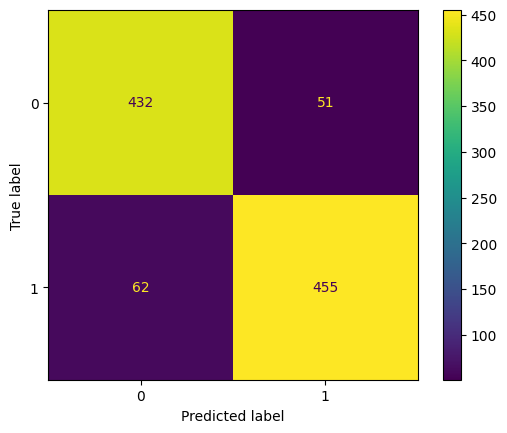

-----------------------------------------------------
DATASET: imdb_md
Accuracy score: 0.8986
Precision score: 0.8921226232052775


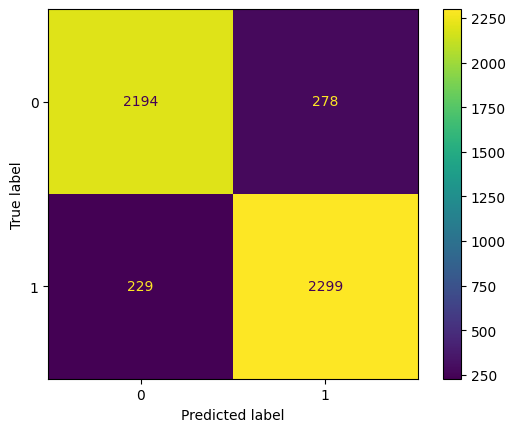

-----------------------------------------------------
DATASET: imdb_lg
Accuracy score: 0.8967368421052632
Precision score: 0.8906266291314774


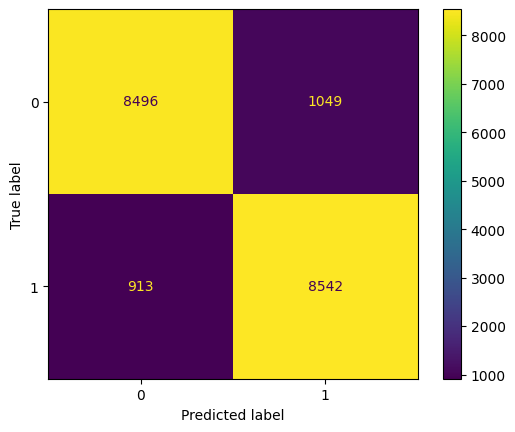

-----------------------------------------------------
DATASET: short_sm
Accuracy score: 0.76
Precision score: 0.8082111436950147


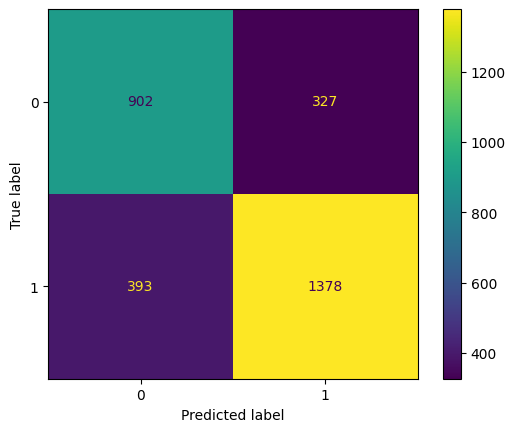

-----------------------------------------------------
DATASET: short_lg
Accuracy score: 0.7633579496090356
Precision score: 0.8289749952280969


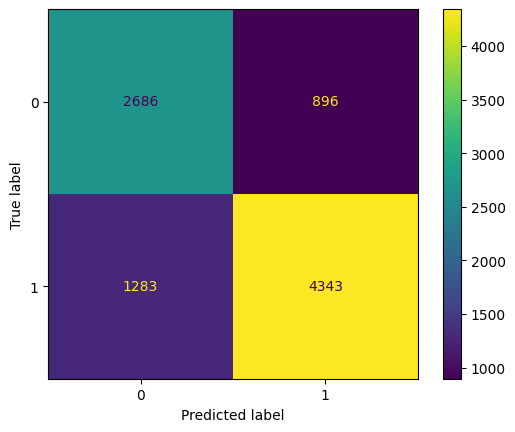

-----------------------------------------------------
DATASET: rotten_mix
Accuracy score: 0.7615
Precision score: 0.8406098406098406


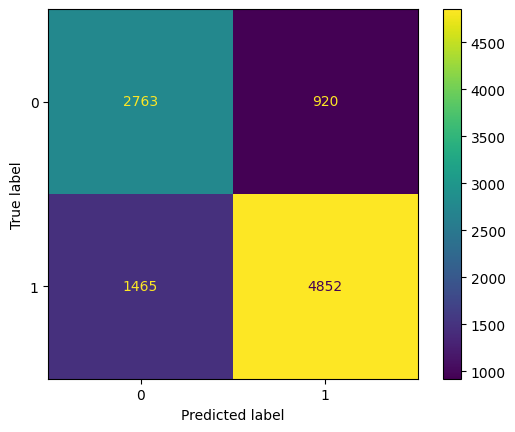

-----------------------------------------------------
DATASET: long (v2+imdb)
Accuracy score: 0.8935515456707231
Precision score: 0.8921242373821409


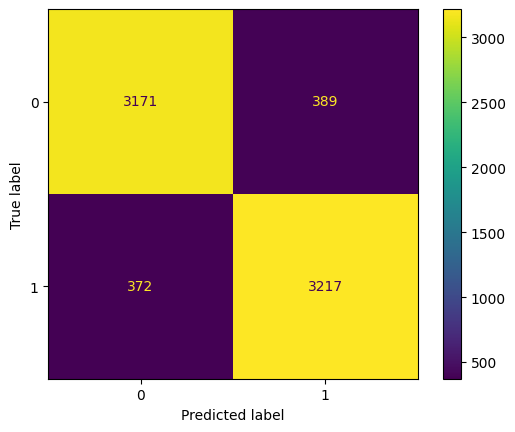

-----------------------------------------------------
DATASET: rest v1(more than 25 tokens)
Accuracy score: 0.7566742944317315
Precision score: 0.7443820224719101


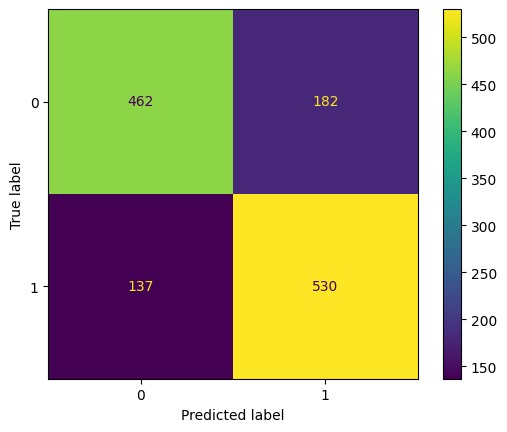

-----------------------------------------------------
DATASET: entire v2
Accuracy score: 0.8965
Precision score: 0.9083419155509783


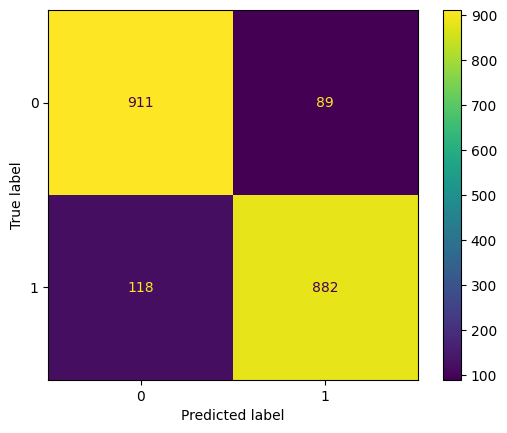

-----------------------------------------------------
DATASET: rotten_pos_only
Accuracy score: 0.768
Precision score: 1.0


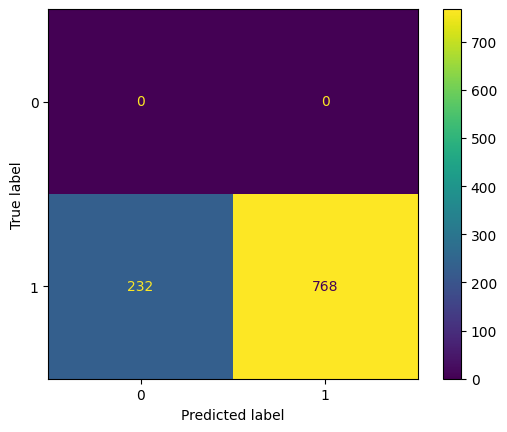

-----------------------------------------------------
DATASET: rotten_neg_only
Accuracy score: 0.733
Precision score: 0.0


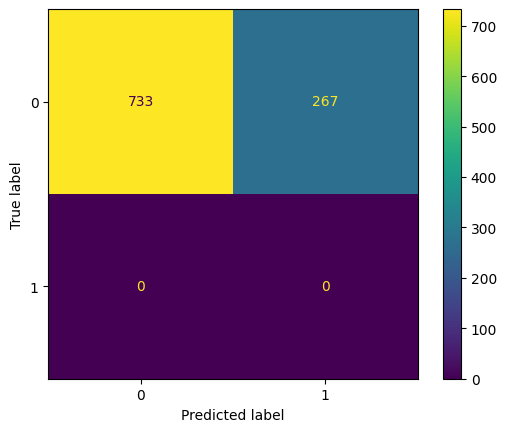

-----------------------------------------------------


In [31]:
results_dict = {}

for (X_test, y_test, name) in encoded_test_sets:
    acc, precision = test_loop(X_test, y_test, set_name=name, model=model)
    acc_key = f"{name}_acc"
    prec_key = f"{name}_prec"
    
    results_dict[acc_key] = acc
    results_dict[prec_key] = precision   

In [ ]:
import json

def write_results(exp_path, results_dict):
    
    res_path = os.path.join(exp_path, 'results.json')
    json_data = json.dumps(results_dict, indent=1)
    
    if os.path.exists(res_path):
        print("Results file already exists for this experiment. Aborting")
        return None
    
    with open(res_path, 'w') as f:
        f.write(json_data)
        
write_results(exp_path=exp_path, results_dict=results_dict)

Initial conclusion: model tends to mislabel mostly negative reviews, thinking they're positive. It could be due to statements like:
*Despite the good cinematography and competent X actor's performance, the movie lacks a gripping narrative and a point to exist besides making money.*

In a review like this, most adjectives are positive bc of the structure like "Some things good, v important thing bad, therefore movie bad"

In [ ]:
exp_path

'models/mind_df_10_ft_20000best/exp1'

In [ ]:
model.module_

SentimentCLF(
  (linear_stack): Sequential(
    (0): Linear(in_features=20000, out_features=500, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.5, inplace=False)
  )
  (final_linear): Linear(in_features=500, out_features=1, bias=True)
)